# Predicting Areas of Affluence using Yelp Pricing Data

#### Authors: 
- Eddie Yip  [GitHub](https://github.com/Tempyst) | [Medium](https://medium.com/@eddie.yip2) | [LinkedIn](https://www.linkedin.com/in/eddie-yip-2a37324b/)
- Hadi Morrow [GitHub](https://github.com/HadiMorrow) | [Medium](https://medium.com/@hadi.a.morrow) | [LinkedIn](https://www.linkedin.com/in/hadi-morrow-4b94164b/)
- Mahdi Shadkam-Farrokhi: [GitHub](https://github.com/Shaddyjr) | [Medium](https://medium.com/@mahdis.pw) | [LinkedIn](https://www.linkedin.com/in/mahdi-shadkam-farrokhi-m-s-8a410958/) | [mahdis.pw](http://mahdis.pw)

## Table of Contents
- [Problem Statement](#Problem-Statement)
    - [Executive Summary](#Executive-Summary)
- [Gathering Data](#Gathering-Data)
- [Loading Data and Libraries](#Loading-Data-and-Libraries)
- [Preliminary Exploratory Data Analysis](#Preliminary-Exploratory-Data-Analysis)
- [Cleaning the Data](#Cleaning-the-Data)
    - [Yelp Price](#Yelp-Price)
    - [Converting Yelp Price to ordinal values](#Converting-Yelp-Price-to-ordinal-values)
    - [Dropping unneccesary columns](#Dropping-unneccesary-columns)
    - [Parsing location data](#Parsing-location-data)
    - [Filtering for NYC-only](#Filtering-for-NYC-only)
    - [Remove by NYC zip](#Remove-by-NYC-zip)
    - [Removing low frequency businesses](#Removing-low-frequency-businesses)
    - [Parsing Yelp Coordinates](#Parsing-Yelp-Coordinates)
    - [Parsing Yelp categories](#Parsing-Yelp-categories)
    - [Parsing Yelp transactions](#Parsing-Yelp-transactions)
- [Cleaning IRS Dataset](#Cleaning-IRS-Dataset)
    - [Merging Yelp and IRS dataset](#Merging-Yelp-and-IRS-dataset)
    - [Changing Data Type](#Changing-Data-Type)
- [Feature Engineering](#Feature-Engineering)
    - [Interaction term: price*rating](#Interaction-term:-price*rating)
    - [The ListColumnExpander class](#The-ListColumnExpander-class)
    - [Creating Dummy Variables](#Creating-Dummy-Variables)
    - [Setting Affluence Threshold](#Setting-Affluence-Threshold)
    - [Reducing Latitude and Longitude into clusters](#Reducing-Latitude-and-Longitude-into-clusters)
    - [Creating "Incomplete" Dataset](#Creating-"Incomplete"-Dataset)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Visualizing location clusters](#Visualizing-location-clusters)
- [Saving/Loading Clean data](#Saving/Loading-Clean-data)
- [Modeling: Two Paths](#Modeling:-Two-Paths)
    - [Establishing baseline model](#Establishing-baseline-model)
    - [Defining scorer object](#Defining-scorer-object)
- [First PATH Full dataset](#First-PATH-Full-dataset)
    - [First Model Preparation](#First-Model-Preparation)
    - [Custom gridSearchHelper function](#Custom-gridSearchHelper-function)
    - [Logistic Model](#Logistic-Model)
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [Bagging](#Bagging)
    - [XGBoost](#XGBoost)
- [Second PATH Feature Reduction](#Second-PATH-Feature-Reduction)
    - [Second Model Preparation](#Second-Model-Preparation)
    - [Second XGBoost Model](#Second-XGBoost-Model)
- [Model Evaluation](#Model-Evaluation)
    - [Summary of Models](#Summary-of-Models)
    - [Interpreting feature importances](#Interpreting-feature-importances)
    - [Inferential Decision Tree](#Inferential-Decision-Tree)
    - [Visualizing Decision Tree](#Visualizing-Decision-Tree)
- [Data Query](#Data-Query)
    - [Verifying predicted affluence](#Verifying-predicted-affluence)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Source Documentation](#Source-Documentation)

## Problem Statement
[⏫ To Top](#Table-of-Contents)

In recent years, natural disasters have become an increasingly prevalent concern. In 2017, Hurricane Maria killed almost 6,000 in Puerto Rico with over \\$90 billion in damages. Hurricane Irma also hit Puerto Rico and southern parts of the US killing over 100 with over \\$60 billion in damages. Wildfires, hurricanes, and floods have become an all too common occurance in the US - [source](https://en.wikipedia.org/wiki/List_of_natural_disasters_in_the_United_States).

In these disaster situations, first responders have the difficult task of deciding where to send initial precious resources. Our client, New Light Technologies, is concerned with utilizing novel data sources as a practical solution to help first responders with these kinds of decisions. In particular, can Yelp "\\$" price data be used to determine the affluence of an area? It is assumed an area's affluence can serve as a marker for disaster-resistance, whereas an area with low affluence have the greatest need. If a reasonable correlation can be found, first responders would be able to quickly assess which areas need relief the most and act accordingly - [source 1](https://www.scientificamerican.com/article/natural-disasters-by-location-rich-leave-and-poor-get-poorer/ ) + [source 2](http://communitystudies.qwriting.qc.cuny.edu/2011/11/09/income-distribution/).

By pulling Yelp data from the Yelp API and matching business location zip codes to IRS data, we determine whether Yelp "\\$" price data correlates with affluence using various supervised learning models. We will restrict our locations to New York City, since it has faced a number of natural disasters and is an area we have subject knowledge in. Also, we will use specificity as our metric for model selection.

## Executive Summary 
[⏫ To Top](#Table-of-Contents)

At the start of this project, our team had some naive assumptions about how strongly the Yelp "\\$" price of a business correlated to the affluency of the area it was in. Namely, we assumed the higher the Yelp price, the higher the affluence. And this is where we first encountered the issue of how we were going to define "affluence".

In our definition of "affluence", we needed to be objective and systematic. After some research, we settled on IRS tax return data. These data showed the tax returns by zip code along with the income brackets for those returns. By looking through each zip code and calculating the proportion of individuals in the highest bracket, we had our "affluency rate". We simply needed to settle on an arbitrary threshold, which we determined through research and subjective selection.

We also debated on which Yelp dataset to use, of which there were two - a large given dataset and the Yelp API. The given dataset was massive but included areas from all over the US with the vast majority being from Arizona. The Yelp API offered us the flexibility to select the locations we wanted to pull data for. Also, these data would be immediately up to date. For these reasons, we settled on using the Yelp API. Regarding location, New York City (NYC) experienced 25% of all the worst, or super severe, disasters occurring in the US from 1930 to 2010, which makes is a priority target for this problem. We also agreed to focus on NYC since each team member was already familiar with NYC and could bring subject knowledge to bear during the process. 
We believed we could use NYC to successfully show a proof of concept for our model.

While modeling, we ran into some issues. First, we had longitude and latitude data for businesses, and we wanted to use them inform our model, but by themselves longitude and latitude were not significant factors. We ended up clustering longitude and latitude to create a new feature, which succinctly summarized the general location of each observation. We also ended up with almost 300 features, to which we had relatively few total observations. Although not a large concern, we decided to explore models using all the variables and, separately, a restricted number of features showing the highest correlation with our target. Lastly, we initially used accuracy as our model metric, but quickly discovered this was not ideal given the problem, which involves emergency response. Our use-case involves potentially sending vital resources to those in the most need - as such we wanted to focus on reducing false negatives and settled on specificity as our main metric.

In all, we set out to discover how related the Yelp "\\$" price is to affluency and we effectively achieved this goal. It was also interesting to discover how significant review ratings and location played in predicting affluency.



## Gathering Data
[⏫ To Top](#Table-of-Contents)

We obtained our data using the Yelp API. Please refer to our [data gathering notebook](yelp_data_gather.ipynb) for specifics on our methodology.

## Loading Data and Libraries
[⏫ To Top](#Table-of-Contents)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import columnExpander
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO  
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

random_state = 6988

In [2]:
data_file_path = "../data/nyc_raw.csv"
df_yelp = pd.read_csv(data_file_path, index_col = 0)
df_yelp.reset_index(drop=True, inplace = True) # same indeces were merged using multiple API calls

In [3]:
df_yelp.shape

(12865, 16)

## Preliminary Exploratory Data Analysis
[⏫ To Top](#Table-of-Contents)

After gathering the data from Yelp, we wanted to examine its current format and what information can be extracted. We also want to determine what information is irrelevant for our analysis. Since the data is raw, there will be information missing for certain businesses and formatting issues at random data points. We will perform cleaning and exploratory data analysis below prior to modeling.

In [4]:
df_yelp.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,mos-original-brooklyn,"[{'alias': 'ramen', 'title': 'Ramen'}, {'alias...","{'latitude': 40.66127, 'longitude': -73.95342}",(718) 513-0698,1542.617156,YwpP-mgXV5N35xhLibLw5g,https://s3-media2.fl.yelpcdn.com/bphoto/-L9roT...,False,"{'address1': '453 Rogers Ave', 'address2': Non...",Mo's Original,1.718513e+10,NaN,4.5,32,[],https://www.yelp.com/biz/mos-original-brooklyn...
1,peaches-hothouse-brooklyn,"[{'alias': 'southern', 'title': 'Southern'}, {...","{'latitude': 40.6833699737169, 'longitude': -7...",(718) 483-9111,3471.525420,GA5msU6NO9rQRctPfDJCBg,https://s3-media1.fl.yelpcdn.com/bphoto/KEAXgZ...,False,"{'address1': '415 Tompkins Ave', 'address2': '...",Peaches HotHouse,1.718484e+10,$$,4.0,1082,"['pickup', 'delivery']",https://www.yelp.com/biz/peaches-hothouse-broo...
2,claw-daddys-brooklyn,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...","{'latitude': 40.68561, 'longitude': -73.98035}",(347) 318-8893,5062.337404,1x2hn3e9sCCZca1cnRTpEg,https://s3-media3.fl.yelpcdn.com/bphoto/ABHo2x...,False,"{'address1': '31 3rd Ave', 'address2': '', 'ad...",Claw Daddy's,1.347319e+10,$$,4.0,282,['restaurant_reservation'],https://www.yelp.com/biz/claw-daddys-brooklyn?...
3,barons-brooklyn,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 40.6908116, 'longitude': -73.953915}",(718) 230-7100,4451.492133,GxMhN2PEttvw7CRGIzB6Gg,https://s3-media3.fl.yelpcdn.com/bphoto/VmnsId...,False,"{'address1': '564 Dekalb Ave', 'address2': '',...",Baron's,1.718231e+10,$$,4.5,258,"['pickup', 'restaurant_reservation']",https://www.yelp.com/biz/barons-brooklyn?adjus...
4,lowerline-brooklyn-2,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...","{'latitude': 40.67421, 'longitude': -73.96324}",(347) 533-7110,3158.955607,swKXaURwqdSrSTcpHsxdbA,https://s3-media4.fl.yelpcdn.com/bphoto/oJbAhL...,False,"{'address1': '794 Washington Ave', 'address2':...",Lowerline,1.347534e+10,$$,4.5,118,[],https://www.yelp.com/biz/lowerline-brooklyn-2?...


In [5]:
sum_null = df_yelp.isnull().sum()
sum_null[sum_null > 0]

display_phone     827
image_url         447
phone             827
price            2187
dtype: int64

We have many missing values in the data, however many of the columns are not meaningful for our problem and these columns can be safely dropped.

Also, `categories`, `location`, and `transactions` are compressed data columns and will need to be unpacked.

## Cleaning the Data
[⏫ To Top](#Table-of-Contents)

### Yelp Price
[⏫ To Top](#Table-of-Contents)

In [6]:
df_yelp["price"].isnull().sum()

2187

We decided to drop null prices from analysis as this is the key indicator we're looking to predict with.

In [7]:
df_yelp.dropna(subset=["price"], inplace = True)

In [8]:
df_yelp.shape

(10678, 16)

### Converting Yelp Price to ordinal values
[⏫ To Top](#Table-of-Contents)

In [9]:
df_yelp['price'] = df_yelp['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$':4})

In [10]:
df_yelp['price'].value_counts()

2.0    5992
1.0    3848
3.0     684
4.0     152
Name: price, dtype: int64

We find that the vast majority of Yelp "\\$" price observations are 2 "\\$$" and 1 "\\$".

### Dropping unneccesary columns
[⏫ To Top](#Table-of-Contents)

In [12]:
keepers = ['categories','id', 'location', 'price', 'rating', 'review_count', 'transactions', 'coordinates']
df_yelp = df_yelp[keepers]

### Parsing location data
[⏫ To Top](#Table-of-Contents)

In [13]:
def get_keys_from_sting_dict(string, keys):
    '''Returns a parsed dictionary given a string-like dictionary and keys to extract'''
    if len(string) == 0:
        return None
    dic = literal_eval(string)
    out = {}
    for key in keys:
        out[key] = dic.get(key)
    return out

In [14]:
location = "location"
keys = ["zip_code", "city", 'state']
zips_and_cities = df_yelp[location].map(lambda string: get_keys_from_sting_dict(string, keys))

for key in keys:
    df_yelp[key] = [pair[key] for pair in zips_and_cities]
    
df_yelp.drop(columns=[location], inplace = True)

### Filtering for NYC-only
[⏫ To Top](#Table-of-Contents)

#### Removing non-NY state
We're only focusing on NYC, so an initial clearing of non-NY states will help remove most of the extraneous observations.

In [15]:
df_yelp = df_yelp[df_yelp['state'] == "NY"]

#### Imputing missing zip codes

In [16]:
df_yelp[df_yelp['zip_code'] == ""]

,categories,id,price,rating,review_count,transactions,coordinates,zip_code,city,state
6940,"[{'alias': 'cupcakes', 'title': 'Cupcakes'}, {...",ECY0sIYxPJio81dteqiMhg,2.0,4.5,16,[],"{'latitude': 40.71455, 'longitude': -74.00714}",,New York,NY
8092,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",6u5cnsN35mJz24HMQ9pfFw,2.0,2.0,15,[],"{'latitude': 40.605271, 'longitude': -74.149243}",,Staten Island,NY
10283,"[{'alias': 'foodstands', 'title': 'Food Stands'}]",BilbRcNQXKmcBFvLm4gxAQ,2.0,5.0,3,[],"{'latitude': 40.7488639529741, 'longitude': -7...",,Queens,NY
10401,"[{'alias': 'farmersmarket', 'title': 'Farmers ...",jZzbV6SRt9FXdCoziNv5xw,2.0,4.0,4,[],"{'latitude': 40.7454635299775, 'longitude': -7...",,Queens,NY
11553,"[{'alias': 'newamerican', 'title': 'American (...",9XXQ2w3DCFytsjjb3KmU7g,4.0,4.0,9,[],"{'latitude': 40.7547945055886, 'longitude': -7...",,New York,NY


All of these locations and their zip codes were found using [Google Maps](https://www.google.com/maps).

In [17]:
df_yelp.loc[df_yelp["id"] == "ECY0sIYxPJio81dteqiMhg","zip_code"] = "10007"
df_yelp.loc[df_yelp["id"] == "6u5cnsN35mJz24HMQ9pfFw","zip_code"] = "10314"
df_yelp.loc[df_yelp["id"] == "BilbRcNQXKmcBFvLm4gxAQ","zip_code"] = "11372"
df_yelp.loc[df_yelp["id"] == "jZzbV6SRt9FXdCoziNv5xw","zip_code"] = "11373"
df_yelp.loc[df_yelp["id"] == "9XXQ2w3DCFytsjjb3KmU7g","zip_code"] = "10017"

### Remove by NYC zip
[⏫ To Top](#Table-of-Contents)

We used the range of zip codes designated for NYC to filter out any businessed out of NYC - [source](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)

In [18]:
min_zip = 10001
max_zip = 11697

df_yelp['zip_code'] = df_yelp['zip_code'].astype(int)

In [19]:
df_yelp = df_yelp[(df_yelp['zip_code'] >= min_zip) & (df_yelp['zip_code'] <= max_zip)]

### Removing low frequency businesses
[⏫ To Top](#Table-of-Contents)

In order to ensure a stable model, we're only going to consider zip codes with a moderate number of 15 businesses. This number is arbitrary.

In [20]:
freq_treshold = 15
zip_counts = df_yelp["zip_code"].value_counts()
low_count_zip_counts = zip_counts[zip_counts < freq_treshold].index
high_count_zip_counts = zip_counts[zip_counts >= freq_treshold].index

In [21]:
df_yelp = df_yelp[[zip_code in high_count_zip_counts for zip_code in df_yelp["zip_code"]]]

### Parsing Yelp Coordinates
[⏫ To Top](#Table-of-Contents)

We are extracting latitude and longtitude data from the coordinates column in order to better filter businesses.

In [22]:
coordinates = "coordinates"
coord_keys = ["latitude", "longitude"]
lat_and_long = df_yelp[coordinates].map(lambda string: get_keys_from_sting_dict(string, coord_keys))

for key in coord_keys:
    df_yelp[key] = [pair[key] for pair in lat_and_long]

df_yelp.drop(columns=[coordinates], inplace = True)

In [23]:
df_yelp[coord_keys].describe()

,latitude,longitude
count,9984.000000,9984.000000
mean,40.731624,-73.913482
std,0.078977,2.094313
min,40.508927,-74.251140
25%,40.683437,-73.988638
50%,40.740916,-73.959225
75%,40.765870,-73.886826
max,41.004690,74.000792


Looking at the latitude and longitude, we see some points that do not appear to be in the New York City area, around 40.7 and -73.9, respectively.

#### Wrong latitude

In [24]:
df_yelp[(df_yelp["latitude"] > 41) | (df_yelp["latitude"] < 40)]

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude
3224,"[{'alias': 'tradamerican', 'title': 'American ...",_pe4POL8iJPohFqPvWehIg,2.0,4.0,857,[],10583,Scarsdale,NY,41.00469,-73.81312


This data point is from Scarsdale NY, which is not within the city limits. This data point will be dropped.

In [25]:
df_yelp = df_yelp[(df_yelp["latitude"] <= 41) & (df_yelp["latitude"] >= 40)]

#### Wrong longitude

In [26]:
df_yelp[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75)]

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude
3306,"[{'alias': 'pizza', 'title': 'Pizza'}]",S2mqyVGw817y9GTHxYRPjw,1.0,4.0,58,[],10472,Bronx,NY,40.830034,73.850772
8560,"[{'alias': 'icecream', 'title': 'Ice Cream & F...",dF02U8Yhxnm66Np4Adgovg,2.0,4.0,290,[],10012,New York,NY,40.723884,74.000792


After looking up these businesses, it is clear they were given a positive longitude when they are actually supposed to be negative.

In [27]:
df_yelp.loc[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75),"longitude"] = np.negative(df_yelp[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75)]["longitude"])

### Parsing Yelp categories
[⏫ To Top](#Table-of-Contents)

The `categories` column is condensed as a dictionary. By selecting the `alias` and reassigning the column as a string of categories, this process prepares the column for later conversion into dummy variables.

In [28]:
def convert_string_dict_to_string(string, key):
    '''Returns a string of a string-link dictionary given extraction keys'''
    return ",".join([dic[key] for dic in literal_eval(string)])

df_yelp["categories"] = df_yelp["categories"].map(lambda s: convert_string_dict_to_string(s,"alias"))

### Parsing Yelp transactions
[⏫ To Top](#Table-of-Contents)

Similarly, the `transactions` column is condensed as a list, which will also be parsed and prepped for later conversion into dummy variables.

In [29]:
def convert_string_list_to_string(string):
    return ",".join(literal_eval(string))

df_yelp["transactions"] = df_yelp["transactions"].map(convert_string_list_to_string)

In [30]:
df_yelp.shape

(9983, 11)

In [31]:
df_yelp.isnull().sum().sum()

0

There are no null values - this is a complete dataset

## Cleaning IRS Dataset
[⏫ To Top](#Table-of-Contents)

These data were collected directly from the IRS website ([source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi))

In [32]:
df_irs = pd.read_csv('../data/irs.csv')

In [33]:
yelp_zips = list(set(df_yelp['zip_code']))

In [34]:
def clean_str_num(str_num):
    '''Returns integer of input string with commas removed'''
    return int(str_num.replace(',',''))

The loop below matches zip codes corresponding to the IRS data and adhering the appropriate affluency rate per zip code.

In [35]:
affluency_rates = []
found_zips = []
missing_zips = []
returns_col_name = 'Number of returns'

for zip_code in yelp_zips:
    try:
        sub_df               = df_irs[df_irs.iloc[:,0] == str(zip_code)]
        
        affluent_irs_returns = clean_str_num(sub_df[returns_col_name].iloc[-1])
        total_irs_returns    = clean_str_num(sub_df[returns_col_name].iloc[0])
        affluent_rate        = affluent_irs_returns / total_irs_returns
        
        affluency_rates.append(affluent_rate)
        found_zips.append(zip_code)
    except Exception as e:
        missing_zips.append(zip_code)
        pass

In [36]:
print("Zip codes founds in Yelp dataset, but missing in IRS dataset: ", ", ".join([str(zipcode) for zipcode in missing_zips]))
len(missing_zips)

Zip codes founds in Yelp dataset, but missing in IRS dataset:  10281, 11430, 10455, 10459, 10020, 10169, 11239, 11249


8

There are 8 zip codes in the yelp data that were not found in the IRS dataset.  
These associated datapoints will be dropped, as they have not target value.

In [37]:
affluency_df = pd.DataFrame(data = {"zip_code": found_zips, "affluency_rate":affluency_rates})
affluency_df.head()

,zip_code,affluency_rate
0,10801,0.052004
1,10803,0.300000
2,10301,0.047013
3,10302,0.018564
4,10304,0.045132


### Merging Yelp and IRS dataset
[⏫ To Top](#Table-of-Contents)

Merging the yelp dataset with the IRS dataset will drop those observations with missing zip codes.

In [38]:
df = pd.merge(df_yelp, affluency_df, on = "zip_code")

In [39]:
df.shape

(9809, 12)

### Changing Data Type
[⏫ To Top](#Table-of-Contents)


In [40]:
df.dtypes

categories         object
id                 object
price             float64
rating            float64
review_count        int64
transactions       object
zip_code            int32
city               object
state              object
latitude          float64
longitude         float64
affluency_rate    float64
dtype: object

The `rating` feature is descrete and should be integers, not floats.

In [41]:
convert_to_int = ["review_count"]
df[convert_to_int] = df[convert_to_int].astype(int)

In [42]:
df.head(2)

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude,affluency_rate
0,"southern,tradamerican,bars",GA5msU6NO9rQRctPfDJCBg,2.0,4.0,1082,"pickup,delivery",11216,Brooklyn,NY,40.683370,-73.94378,0.022398
1,"gastropubs,tradamerican",KkAtVVjnMfb1vGlcpzmhgw,2.0,4.0,303,"pickup,delivery",11216,Brooklyn,NY,40.677866,-73.95000,0.022398


Performing a final check for null values after cleaning the data.

In [43]:
df.isnull().sum().sum()

0

In [44]:
df.shape

(9809, 12)

We are left with 9809 complete data points

## Feature Engineering
[⏫ To Top](#Table-of-Contents)

### Interaction term: price\*rating
[⏫ To Top](#Table-of-Contents)

This interaction term represents a scoring value that allows for relative comparisons between businesses with varying levels of price and rating.

For example: a restaurant with 4 stars and "\\$" price is not as impressive as a restaurant with 4 stars and "\\$\\$\\$\\$" price. 

In [45]:
df["price*rating"] = df["price"] * df["rating"]

### The `ListColumnExpander` class
[⏫ To Top](#Table-of-Contents)

Our dataset came with columns with compressed data, which requiring parsing.
In particular, each observation effectively belonged to multiple categories and featured multiple types of transactions.

_For example, a restaurant could be categorized as "New American", "Ramen", and "Ice Cream". And could offer "delivery" and "pickup"._

This proved challenging to dummify, as this compact format does not follow traditional patterns expected by `pd.get_dummies()`. The need to convert these compact data columns lead to the creation of the custom `ListColumnExpander` class.

`ListColumnExpander` follows standard sklearn transformer paradigms, and inherets directly from the `TransformerMixin` class.

__Functionality__: `ListColumnExpander` initializes with a list of column names (the compressed data columns). After fitting, the `ListColumnExpander` object transforms a dataframe into a sparse matrix of the appropriate dummy data.

_Source code can be found [here](./columnExpander.py)_

### Creating Dummy Variables
[⏫ To Top](#Table-of-Contents)


In [46]:
expansion_columns = ["categories","transactions"]
lce = columnExpander.ListColumnExpander(expansion_columns)

dummy_df = pd.DataFrame(lce.fit_transform(df).toarray(), columns=lce.get_feature_names())

complete_df = pd.concat([df.drop(columns = expansion_columns), dummy_df], axis=1)
complete_df.head(2)

,id,price,rating,review_count,zip_code,city,state,latitude,longitude,affluency_rate,...,categories_organic_stores,categories_skishops,categories_boattours,categories_iberian,categories_streetvendors,categories_sportsbars,transactions_pickup,transactions_,transactions_delivery,transactions_restaurant_reservation
0,GA5msU6NO9rQRctPfDJCBg,2.0,4.0,1082,11216,Brooklyn,NY,40.683370,-73.94378,0.022398,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,KkAtVVjnMfb1vGlcpzmhgw,2.0,4.0,303,11216,Brooklyn,NY,40.677866,-73.95000,0.022398,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


### Setting Affluence Threshold
[⏫ To Top](#Table-of-Contents)

Affluency = when a zip code has 15% of its population file and IRS return of $200k or more

In [47]:
affluency_thresh = .15

In [48]:
complete_df["is_affluent"] = (complete_df["affluency_rate"] >= affluency_thresh).astype(int)
complete_df["is_affluent"].value_counts(normalize = True)

0    0.704557
1    0.295443
Name: is_affluent, dtype: float64

About 30% of all reported IRS returns in New York City count as being affluent, according to our definition.

This leads our data to be somewhat unbalanced, which we need to keep in mind when evaluating our models.

### Reducing Latitude and Longitude into clusters
[⏫ To Top](#Table-of-Contents)

We decided to reduce the latitude and longitude variables into a single column using $K$-means clustering as a way of representing more local neighborhoods.

An optimum $k$ will be determined using the model's silhouette and inertia scores. A high silhouette and low inertia score make for an optimum $k$.

In [80]:
def get_kmean_scores(data, k, random_state = random_state):
    '''Returns the silhouette and inertia scores of a given data with a given k using K-Means clustering'''
    model = KMeans(n_clusters = k, n_jobs = -1, random_state = random_state).fit(data)
    return (silhouette_score(data,model.labels_), model.inertia_)

In [97]:
#Setting up K-means scree plot
max_k = 14
sc = StandardScaler()
lat_long_df = sc.fit_transform(complete_df[["latitude","longitude"]]) # not 100% necessary to scale
sils = []
inerts = []
best_k = {"k":0,"score":0}
all_k  = range(2, max_k + 1)
best_km = None
for k in all_k:
    sil, inertia = get_kmean_scores(lat_long_df, k)
    sils.append(sil)
    inerts.append(inertia)
    if sil > best_k["score"]:
        best_k["score"] = sil
        best_k["k"] = k

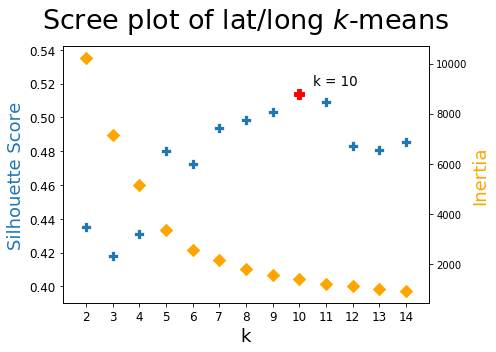

In [112]:
# MAKE THIS LINE GRAPH
size = 18
plt.figure(figsize=(7,5))
plt.title("Scree plot of lat/long $k$-means", fontsize = size*3/2, pad = size)
plt.xlabel("k", fontsize = size)
plt.ylabel("Silhouette Score", fontsize = size, color = "#1f77b4")
g = sns.scatterplot(all_k, sils, s = size * 6, marker = "P")
plt.tick_params(labelsize=size * 2/3)
plt.plot(best_k["k"],best_k["score"], "rP", markersize = size * 3/5)
plt.text(best_k["k"] + .5, best_k["score"] + .005, "k = {}".format(best_k['k']), fontsize = size * 3/4);
g.set_xticks(all_k);

ax2 = plt.twinx()
w = sns.scatterplot(all_k, inerts, s = size * 6, ax = ax2, color="orange", marker = "D")
ax2.set_ylabel("Inertia", fontsize = size, color = "orange")
plt.tight_layout();

According to the silhouette and inertia scores, an optimum number of clusters for longitude and latitude occur is 10.

In [52]:
km = KMeans(n_clusters= best_k["k"], random_state = random_state)
km.fit(lat_long_df)
complete_df["location_cluster"] = km.labels_

# Creating dummy columns for locations
location_dummies = pd.get_dummies(complete_df["location_cluster"], prefix="location_cluster", drop_first=True)
complete_df = pd.concat([complete_df, location_dummies], axis=1)

### Creating "Incomplete" Dataset
[⏫ To Top](#Table-of-Contents)

As a proof of concept and practical use-case, we're interested in allowing a user to input a NYC zip code and quickly know the affluency of the area. This would allow emergency responders to quickly assess which areas are in the most need. This application is explained in more detail in the [Data Query](#Data-Query) section.

Having an incomplete dataset (which includes observations without affluency) allows us to pass the pertinent information about a zip code through our model to make a prediction for the affluency of the area.

In [53]:
# merging IRS data
temp_incomplete_df = pd.merge(df_yelp, affluency_df, on = "zip_code", how = 'outer')

# correcting data types
temp_incomplete_df[convert_to_int] = temp_incomplete_df[convert_to_int].astype(int)

# creating interaction term
temp_incomplete_df["price*rating"] = temp_incomplete_df["price"] * temp_incomplete_df["rating"]
temp_incomplete_df["is_affluent"] = (temp_incomplete_df["affluency_rate"] >= affluency_thresh).astype(int)

# adding dummy columns
dummy_incomplete_df = pd.DataFrame(lce.transform(temp_incomplete_df).toarray(), columns=lce.get_feature_names())
incomplete_df = pd.concat([temp_incomplete_df.drop(columns = expansion_columns), dummy_incomplete_df], axis=1)

# location clustering
incomplete_df["location_cluster"] = km.predict(sc.transform(incomplete_df[["latitude","longitude"]]))

# # location dummies
inc_location_dummies = pd.get_dummies(incomplete_df["location_cluster"], prefix="location_cluster", drop_first=True)
incomplete_df = pd.concat([incomplete_df, inc_location_dummies], axis=1)

## Exploratory Data Analysis
[⏫ To Top](#Table-of-Contents)

In [54]:
min_count = 50
group = complete_df.groupby("city")["affluency_rate"]
group_count = group.count()
group_filter_index = group.count().index[group.count() > min_count]

order_of_cities = group.mean()[group_filter_index].sort_values(ascending=False).index

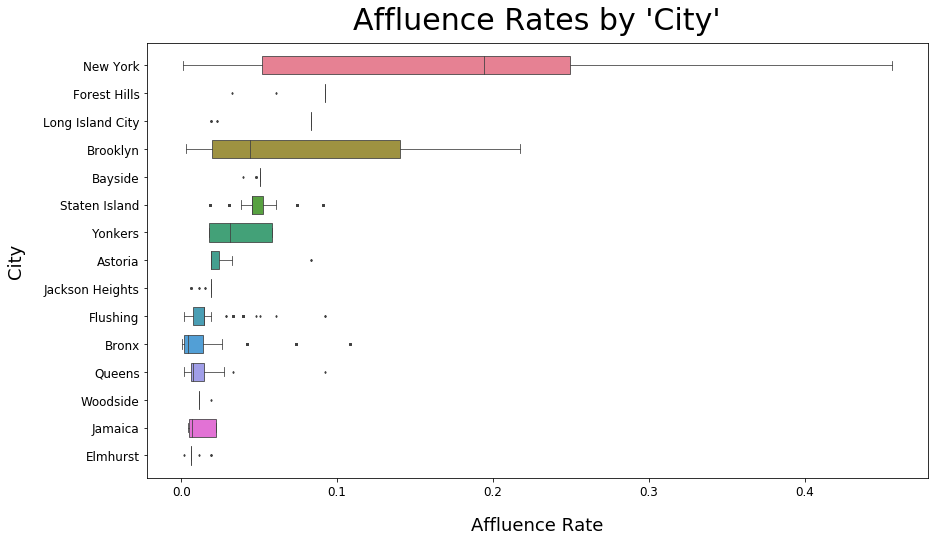

In [55]:
size = 18
plt.figure(figsize = (14,8))
plt.title("Affluence Rates by 'City'", fontsize = size * 5/3, pad = size * 3/4)
g = sns.boxplot(data = complete_df, y = "city", x = "affluency_rate", orient="h", 
            order=order_of_cities, fliersize = 1.5, palette="husl", linewidth = .8, notch = False, width = 0.65);
plt.xlabel("Affluence Rate", fontsize = size, labelpad = size)
plt.ylabel("City", fontsize = size, labelpad = size)
g.tick_params(labelsize = size * 2/3)
g.use_sticky_edges = False
g.margins(y = .02)

Here, we see some correlation between `city` and affluency rate. 

However, using subject knowledge we know these city designations are inconsistent and ambiguous.  
For example, "New York" and "New York City" and "Manhattan" and "new york" and "New york" could be considered synonymous.
The listed "city" appears to be the subjective input from the creator of the Yelp business. Neighborhoods such as "Jackson Heights" are not comparable to "New York City".

__For these reasons we will not be including `city` in our modeling process.__

### Visualizing location clusters
[⏫ To Top](#Table-of-Contents)

The location clusters are an interesting variable, since each cluster succinctly describes how our data is grouped in physical space. As such, visualizing the clusters by physical space can better convey the relationships within our data.

In [56]:
order_of_clusters = complete_df.groupby("location_cluster")["affluency_rate"].mean().sort_values().index

colors = np.array(['#e6194b', '#3cb44b', '#F7B32B', '#4363d8', '#f58231', '#911eb4', '#bcf60c', '#F45866','#46f0f0', '#f032e6'])

neighborhoods = ["Bronx", "Upper Bkln", "Astoria", "Staten Island", "Upper Mhtn", "Lower Bkln", "Lower Mhtn", "Jamaica", "Flushing", "New Rochelle\n&\nYonkers"]

In [57]:
# Prepping geographs
lat      = complete_df['latitude'].values
lon      = complete_df['longitude'].values
price    = complete_df['price'].values
rating   = complete_df['rating'].values

padding  = .05
lat_diff = complete_df["latitude"].max() - complete_df["latitude"].min()
lat_pad  = (lat_diff) * padding

lon_diff = complete_df["longitude"].max() - complete_df["longitude"].min()
lon_pad  = (lon_diff) * padding
size = 18

In [58]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color="w", label=neighborhood, markerfacecolor=color, markersize=15) for color, neighborhood in zip(colors, neighborhoods)]


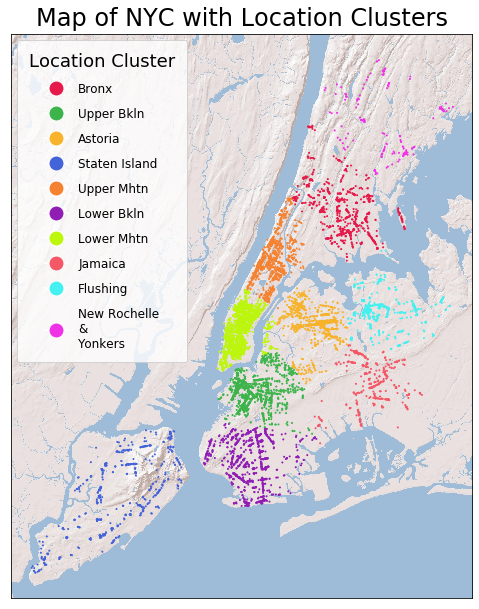

In [59]:
scale = 20
fig = plt.figure(figsize=(lon_diff * scale, lat_diff * scale))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
ax.set_title("Map of NYC with Location Clusters", fontsize = size * 4/3, pad = size /2)
m = Basemap(ax=ax,resolution = None, llcrnrlat = complete_df["latitude"].min() - lat_pad, llcrnrlon = complete_df["longitude"].min() - lon_pad, urcrnrlat = complete_df["latitude"].max() + lat_pad, urcrnrlon = complete_df["longitude"].max() + lat_pad, epsg = 3395)
m.arcgisimage(service ="World_Shaded_Relief", xpixels = 2000)
m.scatter(lon, lat, latlon=True, s = 1, c = colors[complete_df["location_cluster"]]);
ax.legend(handles=legend_elements, loc="upper left", 
          fontsize = size * 2/3, fancybox = True,title="Location Cluster", title_fontsize = size,
          borderpad = 1, labelspacing = 1
         );

The visual above is a color reprentation of clusters overlayed with the actual map of New York City. Clusters were calcutated by running the K-Means model for each data point.

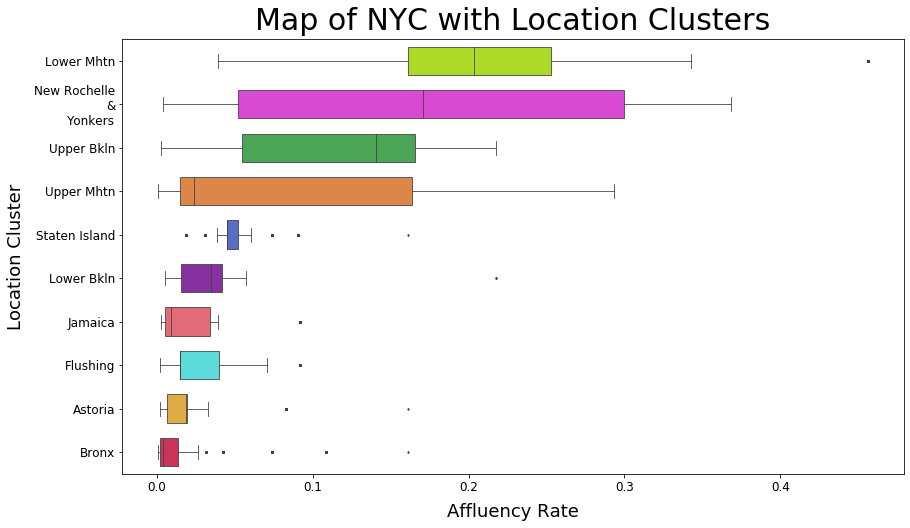

In [60]:
size = 18
plt.figure(figsize = (14,8))
plt.title("Map of NYC with Location Clusters", fontsize = size * 5/3, pad = size/2)
g = sns.boxplot(
    data = complete_df, 
    y = "location_cluster", 
    x = "affluency_rate", 
    order = order_of_clusters[::-1],
    palette = colors[order_of_clusters[::-1]],
    orient="h",
    fliersize = 1.5,
    linewidth = .8, 
    notch = False, 
    width = 0.65
);
g.set_ylabel("Location Cluster", fontsize = size, labelpad = size / 2)
g.set_xlabel("Affluency Rate", fontsize = size, labelpad = size / 2)
g.tick_params(labelsize = size * 2/3)
g.set(yticklabels = np.array(neighborhoods)[order_of_clusters[::-1]]);

The boxplot above shows each cluster's affluency rate distribution. We observe clusters to the left of StatenIsland has a sizeable amount of outliers with high rate of affluency. In addition, the same clusters are rather consistent with their affluency rate while plots to the right of Upper Manhattan shows a wide range of affluency.

In [61]:
# Affluency Geograph prep
scale = 20
zoom = 4.5
norm = Normalize(vmin=0, vmax=1)
mapper = ScalarMappable(norm=norm, cmap="cool")

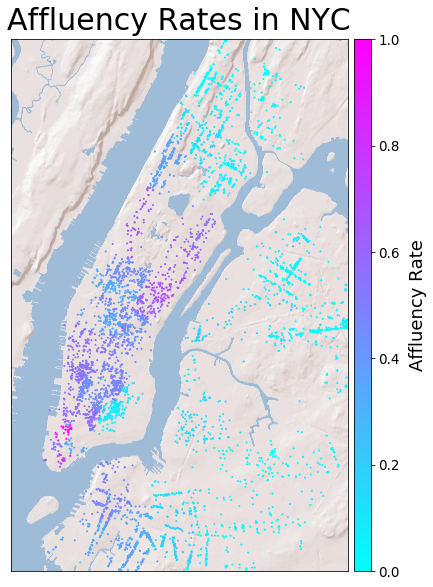

In [62]:
plt.figure(figsize=(lon_diff * scale, lat_diff * scale))
plt.title("Affluency Rates in NYC", fontsize = size * 5/3, pad = size /2)
m = Basemap(
    resolution = None, 
    llcrnrlat = complete_df["latitude"].min() + (lat_pad * zoom) + .05, 
    llcrnrlon = complete_df["longitude"].min() + (lon_pad * zoom) + .1, 
    urcrnrlat = complete_df["latitude"].max() - (lat_pad * zoom) - .05, 
    urcrnrlon = complete_df["longitude"].max() - (lon_pad * zoom) - .05, 
    epsg = 3395)
m.arcgisimage(service ="World_Shaded_Relief", xpixels=2000)
m.scatter(lon, lat, latlon=True, s = 1, cmap ='cool', c = complete_df["affluency_rate"]);
cbar = m.colorbar(mapper)
cbar.set_label('Affluency Rate', size = size, labelpad = size /2)
cbar.ax.tick_params(labelsize=size * 3/4)

This is a focused illustration of Manhattan Island and its affluency rate represented by color. We observed that areas in lower Manhattan is much more affluent than Upper Manhattan with the exception of Upper East side showing shades of purple. In addition, it appears that the Lower East Side is also exhibiting lower rate of affluency compared to the other parts of lower Manhattan.

## Saving/Loading Clean data
[⏫ To Top](#Table-of-Contents)


#### Saving cleaned datasets

In [63]:
# complete_df.to_csv("../data/clean_data.csv")
# incomplete_df.to_csv("../data/clean_incomplete_data.csv")

#### Loading cleaned datasets

In [64]:
complete_df = pd.read_csv("../data/clean_data.csv", index_col = 0)
incomplete_df = pd.read_csv("../data/clean_incomplete_data.csv", index_col = 0)

In [65]:
complete_df.head()

,id,price,rating,review_count,zip_code,city,state,latitude,longitude,affluency_rate,...,location_cluster,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,location_cluster_8,location_cluster_9
0,GA5msU6NO9rQRctPfDJCBg,2.0,4,1082,11216,Brooklyn,NY,40.683370,-73.943780,0.022398,...,1,1,0,0,0,0,0,0,0,0
1,KkAtVVjnMfb1vGlcpzmhgw,2.0,4,303,11216,Brooklyn,NY,40.677866,-73.950000,0.022398,...,1,1,0,0,0,0,0,0,0,0
2,34LM8_lP8iwizHBu6YgaQQ,2.0,4,200,11216,Brooklyn,NY,40.680160,-73.941975,0.022398,...,1,1,0,0,0,0,0,0,0,0
3,ipmOYDh9snm3ZUv546MACQ,1.0,4,178,11216,Crown Heights,NY,40.672984,-73.950312,0.022398,...,1,1,0,0,0,0,0,0,0,0
4,Dv28TvKBh_8i6W02uAaMKw,2.0,4,140,11216,Bedford-Stuyvesant,NY,40.689756,-73.951087,0.022398,...,1,1,0,0,0,0,0,0,0,0


## Modeling: Two Paths
[⏫ To Top](#Table-of-Contents)

With almost 300 features, we were interested in finding an optimal model to determine how significant Yelp prices are in predicting affluency in an area. 
**(This is different from affluency of individual business)**

We considered feature elimination as well as extraction, and decided on trying both. We fit models without altering the data, [PATH 1](#PATH-1:-Default-dataset), as well as with a reduced dataset, [PATH 2](#PATH-2:-Feature-Reduction).

### Establishing baseline model
[⏫ To Top](#Table-of-Contents)

In [66]:
complete_df["is_affluent"].value_counts(normalize = True)

0    0.704557
1    0.295443
Name: is_affluent, dtype: float64

The baseline accuracy for the data is showing that about 70% of the business are not affluent. This means that, if we randomly choose a business from our data set, we have a 70% chance of guessing correctly of the business not being affluent. Because we are optimizing for specificity, we will not observe the accuracay score of our models as the primary metric in determination of the best model.

### Defining scorer object
[⏫ To Top](#Table-of-Contents)

In order to have GridSearchCV properly optimize for our metric, we have to create a sklearn scorer object and provide it as the `scorer` argument.

In [67]:
def spec(y_true,y_pred):
    '''Returns specifity score given true and predicted values'''
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    specificity = (TN)/(TN+FP)
    return specificity

In [68]:
specificity_scorer = make_scorer(spec)

## First PATH Full dataset
[⏫ To Top](#Table-of-Contents)

### First Model Preparation
[⏫ To Top](#Table-of-Contents)

We are removing the following features since they serve no purpose for our modeling analysis.

In [69]:
remove_columns = [
    'id',
    'zip_code',
    'city',
    'state',
    'latitude',
    'longitude',
    'affluency_rate',
    'transactions_',
    'location_cluster',
]
target = 'is_affluent'

In [70]:
X = complete_df.drop(columns=remove_columns+[target])
y = complete_df[target]

In [71]:
X.shape

(9809, 298)

### Custom `gridSearchHelper` function
[⏫ To Top](#Table-of-Contents)

This function simply includes some "quality of life" functionality to help streamline the modeling process, such as printing the training score, test, score and and confusion matrix.

In [72]:
def gridSearchHelper(estimator, params, X, y, standardize = False, scoring = specificity_scorer):
    '''
    A wrapper for GridSearchCV.
    This function abstracts the nuances of fitting a model, such as train/test split, standardizing and
    showing relevant scores.
    
    Params
    ---------
    estimator : 
        `sklearn estimator`
    params : dict
        GridSearchCV grid_params
    X : DataFrame or matrix
        Independent variables
    y : 1-D DataFrame, Series, or matrix
        Target variable
    standardize : bool, default = False
        Flag for whether the data should be standardized before fitting
    scoring : `sklearn` scorer, default = `specifity scorer`
        Scoring metric used to optimize the grid search
        
    Returns
    ---------
    GridSearchCV
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, stratify = y)

    if standardize:
        sc      = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test  = sc.transform(X_test)

    gs = GridSearchCV(estimator, params, cv = 5, n_jobs=-1, scoring = scoring)
    gs.fit(X_train, y_train)
    print("Train score:", gs.best_score_)
    print("Test score:", gs.score(X_test, y_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, gs.predict(X_test)))
    return gs

### Logistic Model
[⏫ To Top](#Table-of-Contents)

In [384]:
lr_params = {'C': [1.023292992280754],
          'penalty': ['l2']}

lr = gridSearchHelper(LogisticRegression(), lr_params, X, y);

Train score: 0.9087398764843112
Test score: 0.9033564814814815
Confusion Matrix:
 [[1561  167]
 [ 190  535]]


Our initial model to predict affluency is the Logistic Model. We want to use the simpliest model as a benchmark to see how it performs. Our model incorporates most of the features engineered with the exception of redundant features removed during the model preparation process. Utilizing gridsearch, we discovered the optimal parameters that gave the highest score for specificity. We want to use specificity as the primary metric because it would not be benefit for improverished neighborhoods to be labeled as affluent in the event of disaster. It can cause the incorrect distribution of resource and aid for those particular neighborhoods.

### K-Nearest Neighbors
[⏫ To Top](#Table-of-Contents)

In [385]:
knn_params = {'n_neighbors': [11],
              'algorithm': ['ball_tree']}

knn = gridSearchHelper(
    KNeighborsClassifier(),
    knn_params, 
    X, y, 
    standardize = True # Must standardize for KNN
);

Train score: 0.8823093066921732
Test score: 0.8778935185185185
Confusion Matrix:
 [[1517  211]
 [ 341  384]]


Our next model will be K-Nearest Neighbors where it functions by grouping up data depending on their proximity. The specificity score here did not surpass the Logistic Model but it was not far off. However, because it did not exceed expections, we will not utilize these models.

### Decision Tree
[⏫ To Top](#Table-of-Contents)

In [386]:
dt_params = {'max_depth': [3],
             'min_samples_split': [2],
             'min_samples_leaf': [1],
             'max_features': [None]}

dt = gridSearchHelper(
    DecisionTreeClassifier(random_state = random_state), 
    dt_params, 
    X, y
);

Train score: 0.9359442262891478
Test score: 0.9305555555555556
Confusion Matrix:
 [[1608  120]
 [ 227  498]]


The DecisionTree Model has delivered desireable results as our confusion has showed that we have greatly reduced our false positives and false negatives. In addition to the low amount of false positives, the model also presented low amount of variance which shows that the data provided had many meaningful and important features that provided this analysis with a fair amount of accuracy. As we continue to explore the models below, we will evaluate other tree-type models and see if improvements can be made whether by either tuning parameters or selecting more robust models. However, with the DecisionTree achieving a score that we see above, we might not see much improvements, if any, that can better examine the data and provide additional accuracy.

### Bagging
[⏫ To Top](#Table-of-Contents)


In [379]:
bc_params = {'n_estimators': [30],
             'max_features': [65]}

bag = gridSearchHelper(
    BaggingClassifier(random_state = random_state), 
    bc_params, 
    X, y
);

Train score: 0.9685508675090322
Test score: 0.9693287037037037
Confusion Matrix:
 [[1675   53]
 [ 505  220]]


As suspected, we generally should not increase complexity of modeling with ensemble methods if DecisionTree already provided great results. Here we see although, the amount of false positives has been greatly reduced, it was at the expense of accuracy and a huge increase in false negatives. Even if the goal is to optimize for specificity, the inbalance of false values is a great concern for the merits of this model. Since Bagging Trees' result kind of regressed, it would not be beneficial to proceed with the other variations that involve bootstrapping and we predict those models, RandomForest, and Extra Trees, will not yeild any interesting results.

### XGBoost
[⏫ To Top](#Table-of-Contents)

In [387]:
boost_params = {'booster': ['gbtree'],
             'max_depth': [3],
             'learning_rate': [.01]}

xgb_1 = gridSearchHelper(
    xgb.XGBClassifier(random_state = random_state), 
    boost_params, 
    X, y
);

Train score: 0.9357512573838845
Test score: 0.9305555555555556
Confusion Matrix:
 [[1608  120]
 [ 227  498]]


One final model we wanted to attempt was the XGBoost (Extreme Gradient Boost) model. While the model performed great, it did not provide any improvement over the DecisionTree model used above. Furthermore, the cores appeared to mirror the DecisiontTree. Although XGBoost was proclaimed to be an extremely robust model that has been proven to be very accurate when used, in this scenario it unforunately did not deliver.

## Second PATH Feature Reduction
[⏫ To Top](#Table-of-Contents)


This model selection path includes a more restrictive look at which features to include.

### Second Model Preparation
[⏫ To Top](#Table-of-Contents)

Correlation was used to find relationship between features where by absolute value was taken such that negatively correlated values were weighed equally. A correlation magnitude of 2% was selected, which minimized the features by 2/3rds. 

In [388]:
feature_cor_threshold = 0.02
cors = abs(complete_df.drop(columns=remove_columns).corr()[target].sort_values(ascending = False)[1:])
reduced_features = cors[cors > feature_cor_threshold].index

reduced_X = complete_df[reduced_features]
reduced_y = complete_df[target]

### Second XGBoost Model
[⏫ To Top](#Table-of-Contents)

In [389]:
XGB_params = { 
    'XGB__n_estimators' : [2]
}

xgb_2 = gridSearchHelper(xgb.XGBClassifier(), XGB_params, reduced_X, reduced_y)

Train score: 0.9160701810873438
Test score: 0.9160879629629629
Confusion Matrix:
 [[1583  145]
 [ 206  519]]


Used GridSearchCV, a parameter finder to search for the best hyper parameter in the XGBoost model. The model scored based on maximizing specificity as above. The result did not show much improvement from the model using all of the features. We hoped that by reducing the amount of features, it would reduce overfitting and present us with a more interesting discovery but it seemed that it was not necessary. 

## Model Evaluation
[⏫ To Top](#Table-of-Contents)

### Summary of Models 
[⏫ To Top](#Table-of-Contents)

After attempting a number of models, the best models can be assessed using our metric of specificity.  

Although a good specifity score is ideal, we began to notice some models would return a specifity of 100% simply by only predicting the negative class. As a way to address this issue, we decided to include an arbitrary requirement during model selection, requiring models to include 5% or less false positive observations in the test dataset. 

We did consider altering our metric to f1-score, as it would take both errors into consideration, but felt more comfortable prioritizing reducing false negatives as opposed to giving both errors equal weight. We created a function below to evaluate all of our models and contrast the differences between them. This will generate a dataframe showing the model and its related statistics.

In [380]:
def eval_model(model, X_train, y_train, X_test, y_test):
    '''
    Evaluates the given model, returning a dictionary the train and test scores, 
    false positive percentage, and accuracy.
    '''
    train_score = model.score(X_train, y_train)
    test_score  = model.score(X_test, y_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    total = sum([tn, fp, fn, tp])
    return {
        "train_score": train_score,
        "test_score" : test_score,
        "perc_fp"    : fp / total,
        "accuracy"   : (tp + tn)/ total
    }

In [381]:
def eval_models(models, X, y, header = True):
    '''Helper function to print markdown-style model evaluations of the given models'''
    if header:
        print("|Model|Train Score|Test Score|False Pos. (%)|Accuracy|")
        print("|-|-|-|-|-|")

    for model in models:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, stratify = y)

        if hasattr(model.best_estimator_,"n_neighbors"): # knn requires standardized data
            sc      = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test  = sc.transform(X_test)
            
        result = eval_model(model, X_train, y_train, X_test, y_test)
        model_name = type(model.best_estimator_).__name__
        
        print("|{}|{:.2%}|{:.2%}|{:.2%}|{:.2%}|".format(model_name, result["train_score"], result["test_score"], result["perc_fp"], result["accuracy"]))

In [390]:
all_models = [lr, knn, dt, bag, xgb_1]

In [391]:
eval_models(all_models, X, y)

|Model|Train Score|Test Score|False Pos. (%)|Accuracy|
|-|-|-|-|-|
|LogisticRegression|91.51%|90.34%|6.81%|85.45%|
|KNeighborsClassifier|90.47%|87.79%|8.60%|77.50%|
|DecisionTreeClassifier|93.58%|93.06%|4.89%|85.85%|
|BaggingClassifier|99.36%|96.93%|2.16%|77.25%|
|XGBClassifier|93.56%|93.06%|4.89%|85.85%|


In [392]:
#xgb_2 uses a reduced dataset 
eval_models([xgb_2], reduced_X, reduced_y, header = False)

|XGBClassifier|92.38%|91.61%|5.91%|85.69%|


|Model|Train Score|Test Score|False Pos. (%)|Accuracy|
|-|-|-|-|-|
|LogisticRegression|91.51%|90.34%|6.81%|85.45%|
|KNeighborsClassifier|90.47%|87.79%|8.60%|77.50%|
|DecisionTreeClassifier|93.58%|93.06%|4.89%|85.85%|
|__BaggingClassifier__|__99.36%__|__96.93%__|__2.16%__|77.25%|
|XGBClassifier #1|93.56%|93.06%|4.89%|85.85%|
|XGBClassifier #2|92.38%|91.61%|5.91%|85.69%|

The Bagged Trees model emerges as having the best training and test specificity scores across all of the models tested. It also features the lowest occurance of false positives. We can see a clear trade off in accuracy for specificity, which was a priority for the emergency scenarios present in the problem.

Additionally, we see all of our models have a higher accuracy than the baseline model, which suggests these models are still better than always predicting "not affluent".

### Interpreting feature importances
[⏫ To Top](#Table-of-Contents)

As our best model, the Bagged Trees gives reliable predictions.

However, in the interest of interpreting feature importances, the Bagged Tree is difficult to represent, as it's true power comes from aggregating predictions from many different models, instead of serving as a model directly. This makes it difficult to summarize which features are most important, since the Bagging model randomizes which features are given to each sub-model (when a `max_features` is set).

Ideally, one model would represent the aggregation of feature importance summarized by the Bagging method. As such, we attempt to represent this aggregation by taking each Decision Tree sub-model and taking the scaled value of each feature deemed important. This allows us to discern the relative importance of all features present and feed the aggregated features into a single Decision Tree.

In [393]:
def get_estimators_features_dict(estimators_features, feature_importances):
    '''
    Returns a dictionary of the given estimators_features by feature index
    
    params:
        estimators_features (list): A list of column indeces representing the features used for each estimator
        feature_importances (list): A list of relative feature_importances

    return:
        dict (hash map) of each column index as a key and a value representing it's scaled importance
    '''
    out = {}
    for i in range(len(estimators_features)):
        for index, importance in zip(estimators_features[i], feature_importances[i]):
            if not out.get(index):
                out[index] = []
            out[index].append(importance)
            
    return {k: sum(v_list)/len(v_list) for k, v_list in out.items()}

#### Aggregating feature importances

In [394]:
# Setting up inputs
estimators_features = bag.best_estimator_.estimators_features_
feature_importances = [estimator.feature_importances_ for estimator in bag.best_estimator_.estimators_]

# establishing aggregated features
agg_feature_importances = get_estimators_features_dict(estimators_features, feature_importances)
agg_feature_importances_df = pd.DataFrame({"indeces": list(agg_feature_importances.keys()), "feature_importance": list(agg_feature_importances.values())}, index = X.columns[list(agg_feature_importances.keys())])

# creating dataframe for functionality
agg_feature_importances_df = agg_feature_importances_df.sort_values("feature_importance",ascending=False)
agg_feature_importances_df[["feature_importance"]].head()

,feature_importance
location_cluster_6,0.786797
review_count,0.624999
price*rating,0.409167
price,0.200375
location_cluster_8,0.162565


The most important aggregated features from the Bagging model make intuitive sense:
1. Location_cluster_6 (Lower Manhattan) is by far the most important factor when considering affluence.
2. The number of reviews a Yelp business has, is also highly correlated with affluence.
3. It's interesting to find the Yelp `price*rating` interaction term as playing a substantial role in predicting affluence.
4. Unsurprisingly, a business' `price` is a good predictor but was not a definitive feature to determine a neighborhood's affluence.
5. Location_cluster_8 (Flushing) is also associated with affluence, although likely with a negative correlation.

### Inferential Decision Tree
[⏫ To Top](#Table-of-Contents)


We will only use features with a non-zero importance, according to the Bagged Trees.  
This inferential model will not be optimized using GridSearch, as the we wish to plot a single aggregated representation of all trees in the Bagged Trees model. 

In [395]:
optimum_X = X.iloc[:,agg_feature_importances_df[agg_feature_importances_df["feature_importance"] > 0]["indeces"]]

opt_gs = gridSearchHelper(
    DecisionTreeClassifier(random_state = random_state), 
    {}, 
    optimum_X, y
)

Train score: 0.8753618166973687
Test score: 0.8651620370370371
Confusion Matrix:
 [[1495  233]
 [ 210  515]]


We observe a lower performance compared to the Bagged Tree. This suggests, unsurprisingly, the aggregate "voting" methodology used in bagging confers better overall predictive power.

As this model is meant to be more informative than predictive, these results are more than acceptable for our visualization needs.

In [449]:
# Prep for Feature Importance Graph 
opt_features_df = pd.DataFrame({"importance": opt_gs.best_estimator_.feature_importances_, "feature": optimum_X.columns})
opt_features_df = opt_features_df.sort_values("importance", ascending = False).iloc[:10]
palette = [(2 * val, val * .5, .5) for val in opt_features_df["importance"]]
opt_features_df["named_features"] = [
    "'Lower\nManhattan'",
    "Review Count",
    "'The Bronx'",
    "'Upper Brooklyn'",
    "'New Rochelle\n& Yonkers'",
    "Price * Rating",
    "Rating",
    "'Italian'",
    "'Bars'",
    "'Delivers'"
]

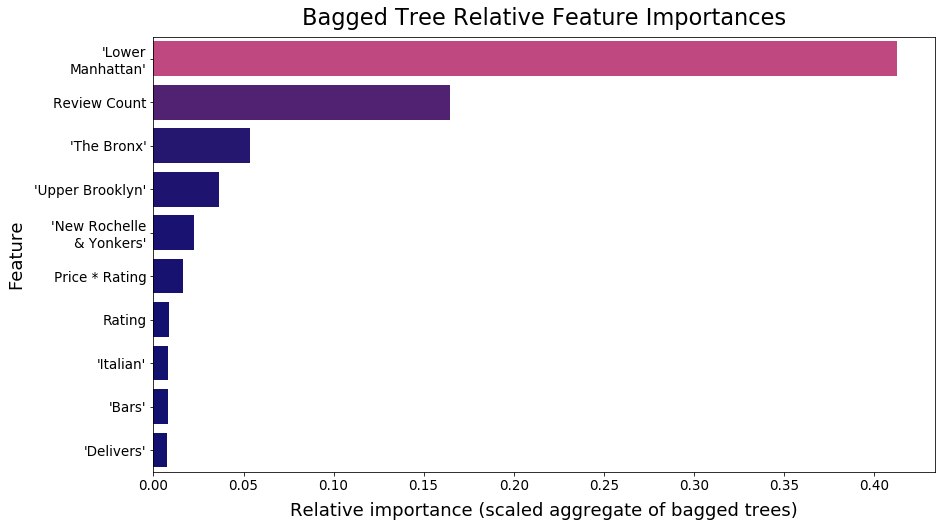

In [450]:
size = 18
plt.figure(figsize=(14,8))
plt.title("Bagged Tree Relative Feature Importances", fontsize = size * 5/4, pad = size * 2/3)
g = sns.barplot("importance", "named_features", data = opt_features_df, orient="h", palette = palette);
plt.ylabel("Feature", fontsize = size, labelpad = size /2)
plt.xlabel("Relative importance (scaled aggregate of bagged trees)", fontsize = size, labelpad = size /2)
g.tick_params(labelsize = size * 3/4)

After running a Decision Tree model using the most important features in aggregate, we can see certain shifts in what factors are prioritized. For example, the #6 cluster (Lower Manhattan) and `review_count` still reign surpreme, but other location clusters play a more significant role, namely:
- #1 = The Bronx (likely negative correlation, given the data)
- #4 = Upper Brooklyn
- #9 = New Rochelle & Yonkers

Interestingly, Yelp `price` is no longer in the top 10 important features, though the interaction term is still present.

### Visualizing Decision Tree
[⏫ To Top](#Table-of-Contents)

In [451]:
# Preparing tree graph
X_train, X_test, y_train, y_test = train_test_split(optimum_X, y, random_state = random_state, stratify = y)
opt_dt = DecisionTreeClassifier()
opt_dt.fit(X_train, y_train)

dot_data = StringIO()

tree.export_graphviz(
    opt_dt,
    out_file = dot_data, 
    class_names = ["not affluent","affluent"],
    max_depth = 3,
    feature_names = optimum_X.columns,
    filled=True, 
    rounded=True,
    special_characters=True,
    impurity=False,
    precision=2
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

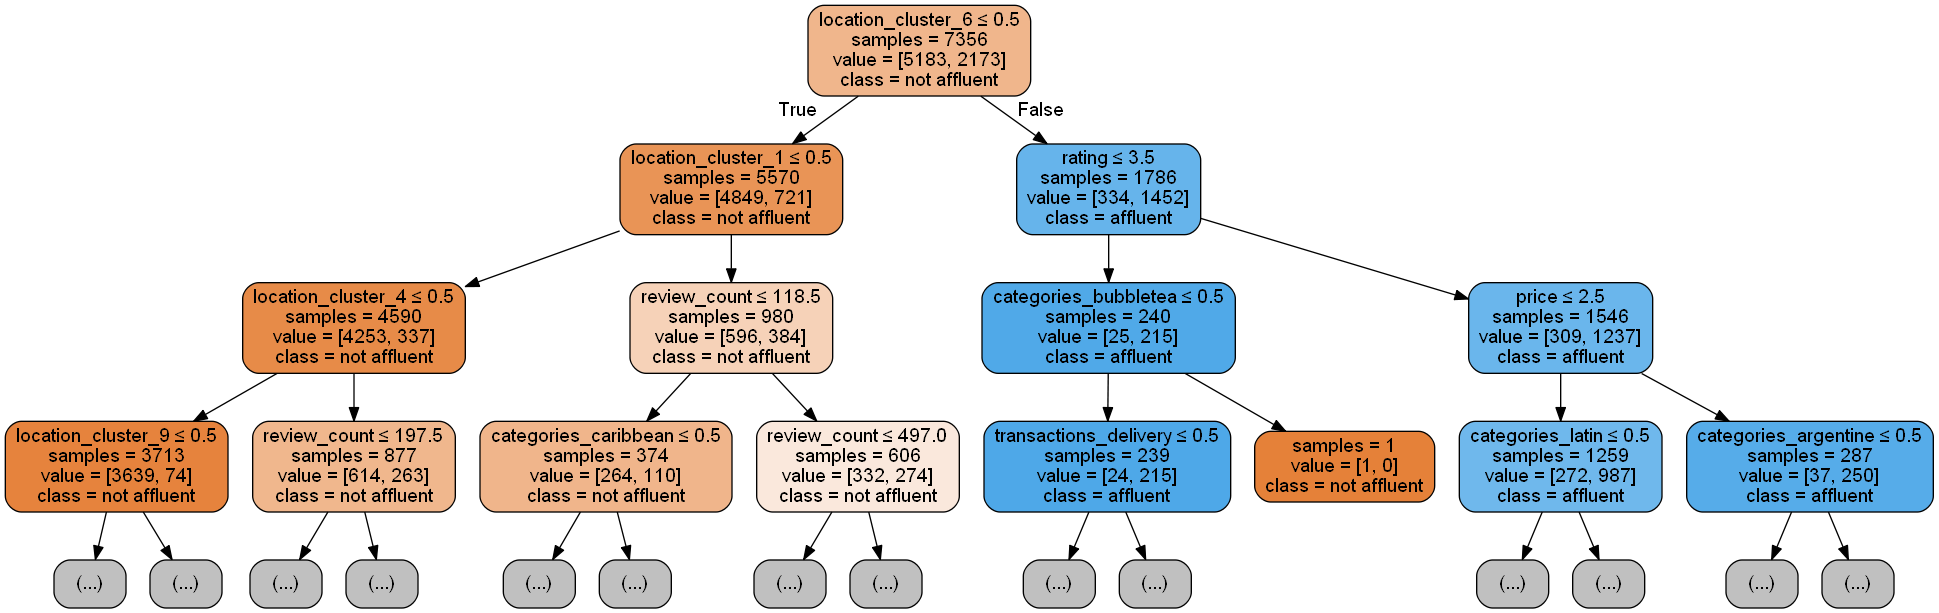

In [452]:
Image(graph.create_png()) #couldn't add title or legend

The image above portrays the methodology on how the DecisionTree model is branching off by using the Gini score. It chooses which feature to branch off by choosing the greatest Gini score decrease from the parent node to the child nodes. We see above that the branches that predicts affluent (positive) has inhibits cool colors while predicting not affluent (negative) has warm colors.  

For the illustration above, it was determined that location cluster 6 (lower Manhattan) was the most important feature in determining the affluency of a neighhood or zip code. The next feature of importance was determined to be ratings that are less than or equal to 3.5 for any businesses. For the not affluent predictions, location cluster 1 (Flushing) was determine to be a significant feature. As the colors reach a darker hue, the gini value decreases, the more definitive the results are for that particular branch (whether the branch predicts affluent or not affluent). For example, a darker blue for that branch means that feature is more pure as it decends through the model for predicting a business is affluent.  

The illustration above is a representation of the Bagging model that we chose to be used for our Query. With our model optimized, we anticipate the query will yield very accurate results when predicting areas that did not have an affluency rate provided due to missing IRS data.

## Data Query
[⏫ To Top](#Table-of-Contents)

With the model of choice in hand, we want to create a query for our client to access to quickly determine if a particular area is affluent so that resources can be distributed properly in times of disaster. Below, a user can input either a zip code or name of a city (for NYC city refers to either the borough or neighborhood name) and it will display the area of interest with its affluency status. 

In [220]:
def query(user_input, model = bag, df = incomplete_df, cdf = complete_df):
    ZIP            = "zip_code"
    AFF_RATE       = "affluency_rate"
    CITY           = "city"
    IS_AFF         = "is_affluent"
    aff_threshold  = 0.15
    out            = None
    remove_columns = [
        'id','zip_code','city','state',
        'latitude','longitude','affluency_rate',
        'transactions_','location_cluster','is_affluent'
     ]

    if type(user_input) == int: # the first check in the function would be to see if the input is a string or an integer
                                # this is to enable the query take both type of values and return their appropriate result
        try: # We want to filter out any non-NYC cities or zipcodes and return a message that this query will only work for NYC area
            query_selection = df[df[ZIP] == user_input]
            
            if query_selection[AFF_RATE].isnull().sum() == 0:
            # For integer type data, the input will be a zipcode; we want to check if that particular zip code
            # already has the affluency rate generated from the IRS data above. If the data exist, we can directly
            # pull the data and display it from the dataframe
                affluency_rate = query_selection[AFF_RATE].iloc[0]
                out = pd.DataFrame({ZIP: user_input, AFF_RATE: affluency_rate}, index = range(1))
                # If the above condition is met, the function will return a dataframe for that particular zipcode
                
            else: # If the zipcode given did not have affluency rate given, we can use our model above to predict
                  # the affluency rate

                y_pred = model.predict(query_selection.drop(columns = remove_columns))
                # We retrieve our predict values from the incomplete file and instantiate that to a variable
                
                out = pd.DataFrame({ZIP: user_input, AFF_RATE: y_pred.mean()}, index= range(1))
                # We return a single row dataframe that outputs the zipcode with its associated affluency rate by taking the 
                # mean of all predicted value (0s and 1s) within the zipcode
        except:
            print('Please enter a valid NYC zipcode.') #returning a prompt for invalid NYC zipcode input
            return
    else: # If the name of the city (neighborhood or borough) is given, we can apply a different method to show the
              # affluency rate for all zipcodes within that region
        city_df = df[df[CITY] == user_input]
        if city_df.shape[0] != 0:
            # We want to filter out cities that are not in NYC with this conditional statement
            
            if city_df[AFF_RATE].isnull().sum() == 0: 
            # Similar to the zipcode application above, if all values of affluency within that data exists, then we will not 
            # need to use our model and predict affluency for that particular region

                zip_code_affluencies = [{ZIP: city_zip, AFF_RATE: city_df[city_df[ZIP] == city_zip][AFF_RATE].iloc[0]} for city_zip in city_df[ZIP].unique()]
                # Because each zip code is repeated multiple times per business, we only need the unique zipcodes within that data
                # For each zipcode that it gets looped through, we only need to take the first value for that zipcode range
                # and append it to the list. The reason for this is the affluency rate for a single zipcode is always the same.
                # We only need to show each zipcode's affluency rate for a given region queried.

                out = pd.DataFrame(zip_code_affluencies)
                # This will return the list created above into a dataframe showing all the zipcodes and their associated affluency rate

            else: # As per above, we have to consider certain regions where some zipcodes did not have their affluency rate provided
                  # by the IRS data
                city_affluency = []
                # Here we also instantiate an empty list to store the zipcodes and their affluency rate after extraction

                for city_zip in city_df[ZIP].unique():
                # As above, we want to only look at unique zip codes since there will be repeats throughout the dataframe
                    city_selection = city_df[city_df[ZIP] == city_zip]

                    if city_selection[AFF_RATE].isnull().sum() == 0:
                    # for the zipcodes that already has affluency rate, we can isolate those values with the condition set above
                        city_affluency.append({ZIP: city_zip, AFF_RATE: city_selection[AFF_RATE].iloc[0]})
                        # we will store all those values within the empty list instantiated above 

                    else: # for the remaining values (i.e. data that were not given by the IRS) we will use our model to predict
                          # the affluency rate for all zipcodes within that region

                        y_pred = model.predict(city_selection.drop(columns = remove_columns))
                        # creating an array of predicted values
                        
                        city_affluency.append({ZIP: city_zip, AFF_RATE: y_pred.mean()})
                        # Appending the list above with the predicted values as an average of affluency

                out = pd.DataFrame(city_affluency)
                # returning the dataframe for that particular region
        
        else: # For cities entered that are not within NYC, the prompt below will appear to alert the user of the error
            print("Please enter a proper city name.")
            return
    # creating boolean column 'is_affluent'
    out[IS_AFF] = (out[AFF_RATE] > aff_threshold).astype(bool)
    # sorting DataFrame by affluency_rate before returning
    return out.sort_values(AFF_RATE)[[ZIP,AFF_RATE, IS_AFF]].reset_index(drop=True)

__The `query` function operates with an input of either a zip or a string of the city's name. This will return a dataframe with the necessary information of that area's affluency.__

In [221]:
query(10001) # zip code with known affluency rate

,zip_code,affluency_rate,is_affluent
0,10001,0.161157,True


In [222]:
query('Bronx').head(10) # Query showing affluency rate for every zipcode in Bronx

,zip_code,affluency_rate,is_affluent
0,10459,0.000000,False
1,10455,0.000000,False
2,10452,0.000552,False
3,10458,0.001166,False
4,10460,0.001194,False
5,10454,0.001263,False
6,10468,0.001683,False
7,10472,0.001731,False
8,10451,0.002147,False
9,10467,0.002240,False


### Verifying predicted affluence
[⏫ To Top](#Table-of-Contents)

We want to evaluate our model that performed the best in terms of specificity and accuracy. Using the query function created from above, we can examine the output for zip codes that did not have an affluency rate given by the IRS data. To properly account for the tools accuracy, it might be necessary to have subject knowledge of NYC's geography to better understand if that particular area does have residents of affluence.

In [223]:
query(11249)

,zip_code,affluency_rate,is_affluent
0,11249,0.222222,True


<img src="../images/11249.png" alt="drawing" width="720"/>

In the query above, the model determined that particular zip code is close to the .15 threshold. Our model predicted this area to have an affluency rate of 11%. We can verify the model [here](https://newyork.hometownlocator.com/zip-codes/data,zipcode,11249.cfm) and see that the average income per household is \\$90,853 with the median household income at \\$57,389. While we are not provided with the proportion of household incomes per income bracket, the area observed is within middle class range.

In [224]:
query(10459)

,zip_code,affluency_rate,is_affluent
0,10459,0.0,False


<img src="../images/10459.png" alt="drawing" width="720"/>

Our final evaluation of the model shows the zip code above to be not affluent. According this [data](https://www.zipdatamaps.com/10455), the average household income is \\$27,060 and the median income is \\$24,406. Similar to the previous neighborhood, this area was classified by our model to be well below our affluence threshold. Providing aid to this neighborhood as a priority would be crucial when disaster occurs.

In [225]:
query(11239)

,zip_code,affluency_rate,is_affluent
0,11239,0.0,False


<img src="../images/11239.png" alt="drawing" width="720"/>

The query for the zip code above predicted that partcular zip is not affluency for any of the businesses as a data point. A verification can be show via [this link](https://www.zipdatamaps.com/11239) where the median housefhold income is \\$21,116 and the average household income is \\$39,110. With income ranges that low, our model appears to accurately classified this neigborhood to be low income based and would benefit from additional disaster relief aid in times of crisis.

In [226]:
query(10020)

,zip_code,affluency_rate,is_affluent
0,10020,0.277778,True


<img src="../images/10020.png" alt="drawing" width="720"/>

The last query we want to present here is a commercial zip code (i.e. all the buildings within this zip code do not have residential capabilities). 10020 was predicted to be a highly affluent area, which is correct (This zip code inhibits the Rockefeller Center Building) and would be categorized as high valued. Likewise, businesses around this area would be considered to be high priced consumer services which coresponds to great amount of affluency. In times of disaster, we can confidently say that this area would probably not need immediate aid. 

## Conclusions and Recommendations
[⏫ To Top](#Table-of-Contents)

#### Conclusion:
We set out to use Yelp "\\$" price to determine the affluency of neighborhoods and our findings show the Yelp \\$ price plays a small, if not insignificant role, in predicting neighborhood affluency.

By far, location was found to be the best determinate for affluency. Also, the sheer number of Yelp comments was another significant determinant. We found this odd, as one would expect review quality to be a better indicator. We suspect the number of Yelp comments is correlating with another factor - foot traffic around commercial areas. It's plausible the businesses in commercial areas have substantially high foot traffic, leading to a high number of Yelp comments.

There were several problems with predicting affluency using these data. Firstly, some data were not well represented. The data was heavily skewed towards 1 "\\$" and 2 "\\$$" prices, which did not allow for a fair representation of all prices. Also, some zip codes are physically larger than others causing small zip codes to over-represent businesses observed in their area.

Also, the IRS data we used only factors in resident citizens and not businesses. This led to several NYC zip code not appearing in the IRS dataset at all. For example, we could not find 10020, a small zip code encompassing the affluent Rockefeller Center. It was not possible to know the true affluency for these missing areas without subject knowledge. This led to some commercial districts skewing our results, since these neighborhoods tend to be affluent, but were misclassified by our model.

It is important to note that despite the false negative misclassification, our model would still effectively steer resources to these needy areas, as they tend to have a high population density.

In the case of an emergency, our query function proves to be a good predictor for where emergency resources should be sent first. Of course, this model only applies to NYC, but shows a proof of concept that could be applicable for other areas.

While working through this problem, we made the following assumptions:
- An area's affluence can serve as a marker for disaster-resistance
- We arbitrarily set an affluency threshold of 15%
- $200,000+ income was the cutoff used to determine the affluency rate for a zip code
- New York City is a representative area for the problem
- A correlation of 2% was used as the cutoff for reducing features, which reduced the number of features by 30%
- We assumed specificity was the best metric

#### Recommendations:
We recommend that emergency services prioritize sending resources to areas with low affluency and high population density. For NYC, our `query` model can be used for this purpose.

For future work, we would be interested in creating a similar model for other locations to test the portability of our process.

Additionally, we would recommend Yelp add an indicator (in their API) to flag if a business is in a commercial area.


## Source Documentation
[⏫ To Top](#Table-of-Contents)

- [NYC zip codes](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)
- [Yelp API - Business Endpoints](https://www.yelp.com/fusion)
- [IRS dataset](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi)